# Performance comparison

This notebook compares the performance of `cuDF` and `pandas`. The comparisons performed are on identical data sizes. This notebook primarily showcases the factor of speedups users can have when the similar `pandas` APIs are run on GPUs using `cudf`.

This notebook is written to measure performance on NVIDIA GPUs with large memory and was tested with a single A100-40GB (~1 hour to run). If using any hardware with smaller memory and/or compute (eg. laptop, workstation), please consider pushing this project to a machine with heavier hardware to run this notebook. Thankfully, NVIDIA AI Workbench makes this process easy!

Alternatively, you may consider lowering the `num_rows` values. 

**Note**: Performance results may vary by data size, as well as the CPU and GPU used. The hardware details used to run these performance comparisons are at the end of this page.

In [1]:
import os
import time
import timeit
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cudf

In [2]:
np.random.seed(0)

## Concat, count & joins performance

In [3]:
num_rows = 150_000_000
pdf = pd.DataFrame(
    {
        "numbers": np.random.randint(-1000, 1000, num_rows, dtype="int64"),
        "business": np.random.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=num_rows
        ),
    }
)
pdf

,numbers,business
0,-316,Buckees
1,-441,Costco
2,653,Costco
3,216,McD
4,-165,Costco
...,...,...
149999995,807,Costco
149999996,-441,Buckees
149999997,-377,Costco
149999998,966,Costco


In [4]:
gdf = cudf.from_pandas(pdf)
gdf

,numbers,business
0,-316,Buckees
1,-441,Costco
2,653,Costco
3,216,McD
4,-165,Costco
...,...,...
149999995,807,Costco
149999996,-441,Buckees
149999997,-377,Costco
149999998,966,Costco


In [5]:
def timeit_pandas_cudf(pd_obj, gd_obj, func, **kwargs):
    """
    A utility function to measure execution time of an
    API(`func`) in pandas & cudf.

    Parameters
    ----------
    pd_obj : Pandas object
    gd_obj : cuDF object
    func : callable
    """
    pandas_time = timeit.timeit(lambda: func(pd_obj), **kwargs)
    cudf_time = timeit.timeit(lambda: func(gd_obj), **kwargs)
    return pandas_time, cudf_time

In [6]:
pandas_value_counts, cudf_value_counts = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.value_counts(), number=30
)

In [7]:
pdf = pdf.head(50_000_000)
gdf = gdf.head(50_000_000)

In [8]:
pandas_concat = timeit.timeit(lambda: pd.concat([pdf, pdf, pdf]), number=30)

In [9]:
cudf_concat = timeit.timeit(lambda: cudf.concat([gdf, gdf, gdf]), number=30)

In [10]:
pandas_groupby, cudf_groupby = timeit_pandas_cudf(
    pdf,
    gdf,
    lambda df: df.groupby("business").agg(["min", "max", "mean"]),
    number=30,
)

In [11]:
num_rows = 500_000
pdf = pd.DataFrame(
    {
        "numbers": np.random.randint(-1000, 1000, num_rows, dtype="int64"),
        "business": np.random.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=num_rows
        ),
    }
)
gdf = cudf.from_pandas(pdf)

In [12]:
pandas_merge, cudf_merge = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.merge(df), number=30
)

In [13]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_value_counts / cudf_value_counts,
            pandas_concat / cudf_concat,
            pandas_groupby / cudf_groupby,
            pandas_merge / cudf_merge,
        ],
    },
    index=["value_counts", "concat", "groupby", "merge"],
)

In [14]:
performance_df

,cudf speedup vs. pandas
value_counts,98.795870
concat,40.988709
groupby,89.501697
merge,52.585589


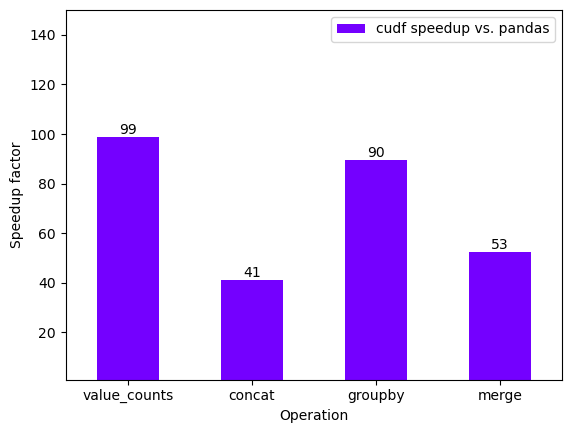

In [15]:
ax = performance_df.plot.bar(
    color="#7400ff",
    ylim=(1, 150),
    rot=0,
    xlabel="Operation",
    ylabel="Speedup factor",
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

In [16]:
# Cleaning up used memory for later benchmarks
del pdf
del gdf
import gc

_ = gc.collect()

## Strings Performance

In [17]:
num_rows = 100_000_000
pd_series = pd.Series(
    np.random.choice(
        ["123", "56.234", "Walmart", "Costco", "rapids ai"], size=num_rows
    )
)

In [18]:
gd_series = cudf.from_pandas(pd_series)

In [19]:
pandas_upper, cudf_upper = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.upper(), number=20
)

In [20]:
pandas_contains, cudf_contains = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.contains(r"[0-9][a-z]"), number=20
)

In [21]:
pandas_isalpha, cudf_isalpha = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.isalpha(), number=20
)

In [22]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_upper / cudf_upper,
            pandas_contains / cudf_contains,
            pandas_isalpha / cudf_isalpha,
        ],
    },
    index=["upper", "contains", "isalpha"],
)

In [23]:
performance_df

,cudf speedup vs. pandas
upper,1012.916918
contains,321.727087
isalpha,3665.660623


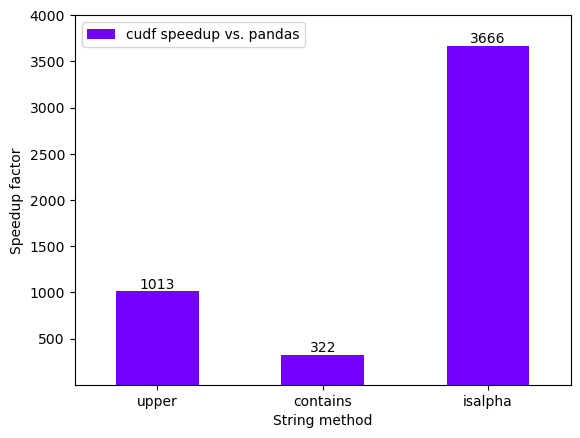

In [24]:
ax = performance_df.plot.bar(
    color="#7400ff",
    ylim=(1, 4000),
    rot=0,
    xlabel="String method",
    ylabel="Speedup factor",
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

## User-defined function (UDF) performance (with JIT overhead)

The first UDF runs include JIT compilation overhead, due to which the performance of first run and average of next few runs are compared separately.

In [25]:
num_rows = 5_000_000
pdf_age = pd.DataFrame(
    {
        "age": np.random.randint(0, 100, num_rows),
    }
)
pdf_age

,age
0,59
1,20
2,86
3,73
4,6
...,...
4999995,18
4999996,86
4999997,18
4999998,7


In [26]:
gdf_age = cudf.from_pandas(pdf_age)
gdf_age

,age
0,59
1,20
2,86
3,73
4,6
...,...
4999995,18
4999996,86
4999997,18
4999998,7


In [27]:
def age_udf(row):
    if row["age"] < 18:
        return 0
    elif 18 <= row["age"] < 20:
        return 1
    elif 20 <= row["age"] < 30:
        return 2
    elif 30 <= row["age"] < 40:
        return 3
    elif 40 <= row["age"] < 50:
        return 4
    elif 50 <= row["age"] < 60:
        return 5
    elif 60 <= row["age"] < 70:
        return 6
    else:
        return 7

In [28]:
pandas_int_udf, cudf_int_udf = timeit_pandas_cudf(
    pdf_age, gdf_age, lambda df: df.apply(age_udf, axis=1), number=1
)

In [29]:
def str_isupper_udf(row):
    if row.isupper():
        return 0
    else:
        return 1

In [30]:
pd_series = pd.Series(
    np.random.choice(["ABC", "abc", "hello world", "AI"], size=50_000_000),
    name="strings",
)
pd_series

0                   abc
1                    AI
2                   ABC
3                   abc
4                    AI
               ...     
49999995            ABC
49999996            abc
49999997    hello world
49999998            abc
49999999             AI
Name: strings, Length: 50000000, dtype: object

In [31]:
gd_series = cudf.from_pandas(pd_series)
gd_series

0                   abc
1                    AI
2                   ABC
3                   abc
4                    AI
               ...     
49999995            ABC
49999996            abc
49999997    hello world
49999998            abc
49999999             AI
Name: strings, Length: 50000000, dtype: object

In [32]:
pandas_str_udf, cudf_str_udf = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.apply(str_isupper_udf), number=1
)

In [33]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_int_udf / cudf_int_udf,
            pandas_str_udf / cudf_str_udf,
        ]
    },
    index=["Numeric", "String"],
)
performance_df

,cudf speedup vs. pandas
Numeric,153.236482
String,108.242918


Below is the plot showing performance speedup in case of Numeric UDFs & String UDFs on their first runs.

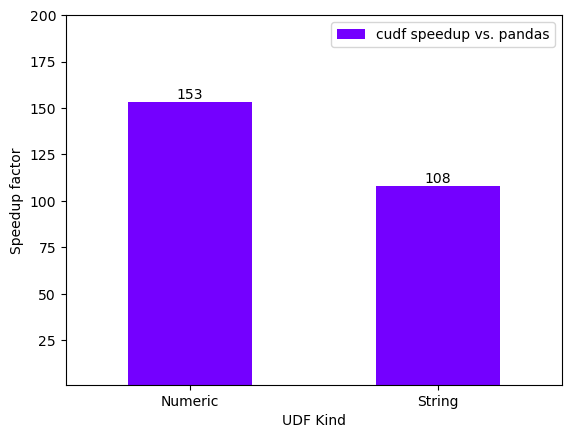

In [34]:
ax = performance_df.plot.bar(
    color="#7400ff",
    ylim=(1, 200),
    rot=0,
    xlabel="UDF Kind",
    ylabel="Speedup factor",
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

## User-defined function (UDF) performance (without JIT overhead)

In [35]:
pandas_int_udf, cudf_int_udf = timeit_pandas_cudf(
    pdf_age, gdf_age, lambda df: df.apply(age_udf, axis=1), number=10
)

In [36]:
pandas_str_udf, cudf_str_udf = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.apply(str_isupper_udf), number=10
)

In [37]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_int_udf / cudf_int_udf,
            pandas_str_udf / cudf_str_udf,
        ]
    },
    index=["Numeric", "String"],
)
performance_df

,cudf speedup vs. pandas
Numeric,20594.774013
String,1609.251766


Below is the plot showing performance speedup in case of Numeric UDFs & String UDFs on their consequent runs. In this case the speedup is massive because of no JIT overhead present.

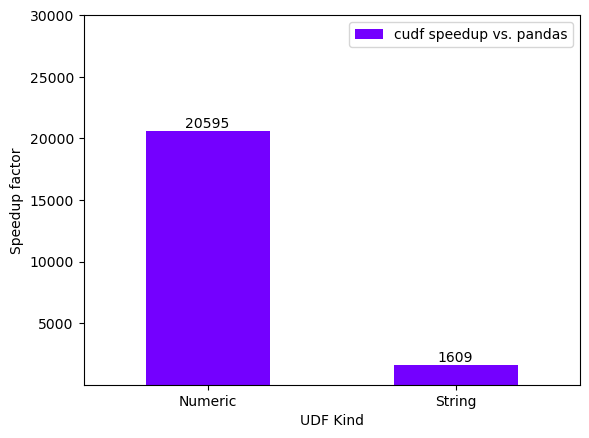

In [38]:
ax = performance_df.plot.bar(
    color="#7400ff",
    ylim=(1, 30000),
    rot=0,
    xlabel="UDF Kind",
    ylabel="Speedup factor",
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

## UDF Performance in GroupBy

In [39]:
num_rows = 50_000_000
pdf = pd.DataFrame()
pdf["key"] = np.random.randint(0, 2, num_rows)
pdf["val"] = np.random.randint(0, 7, num_rows)


def custom_formula_udf(df):
    df["out"] = df["key"] * df["val"] - 10
    return df


gdf = cudf.from_pandas(pdf)

In [40]:
pandas_udf_groupby, cudf_udf_groupby = timeit_pandas_cudf(
    pdf,
    gdf,
    lambda df: df.groupby(["key"], group_keys=False).apply(custom_formula_udf),
    number=10,
)

In [41]:
performance_df = pd.DataFrame(
    {"cudf speedup vs. pandas": [pandas_udf_groupby / cudf_udf_groupby]},
    index=["Grouped UDF"],
)
performance_df

,cudf speedup vs. pandas
Grouped UDF,146.587285


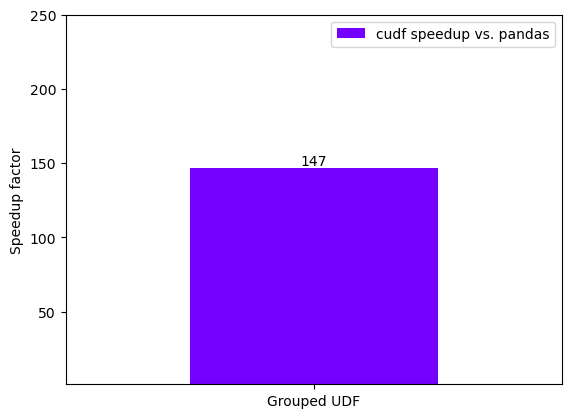

In [42]:
ax = performance_df.plot.bar(
    color="#7400ff", ylim=(1, 250), rot=0, ylabel="Speedup factor"
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

# System Configuration

## CPU Configuration

In [43]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         45 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  32
  On-line CPU(s) list:   0-31
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Gold 6240R CPU @ 2.40GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  1
    Core(s) per socket:  16
    Socket(s):           2
    Stepping:            7
    BogoMIPS:            4788.74
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscal
                         l nx pdpe1gb rdtscp lm constant_tsc arch_perfmon nopl x
                         topology tsc_reliable nonstop_tsc cpuid tsc_known_freq 
                         pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic 
                         movbe popcnt tsc_deadline_timer aes xsav

## GPU Configuration

In [44]:
!nvidia-smi

Fri Sep 22 17:07:12 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off | 00000000:03:00.0 Off |                    0 |
| N/A   31C    P0              56W / 250W |   5029MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--